# Mask Transfer

In [ ]:
!nvidia-smi

Fri Jul 24 05:04:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

画像を読み込み

In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image
import cv2 

import torch 
import torch.nn.functional as F
import torchvision
from torchvision import models, transforms

In [ ]:
img = Image.open("sample_mountain.jpg")

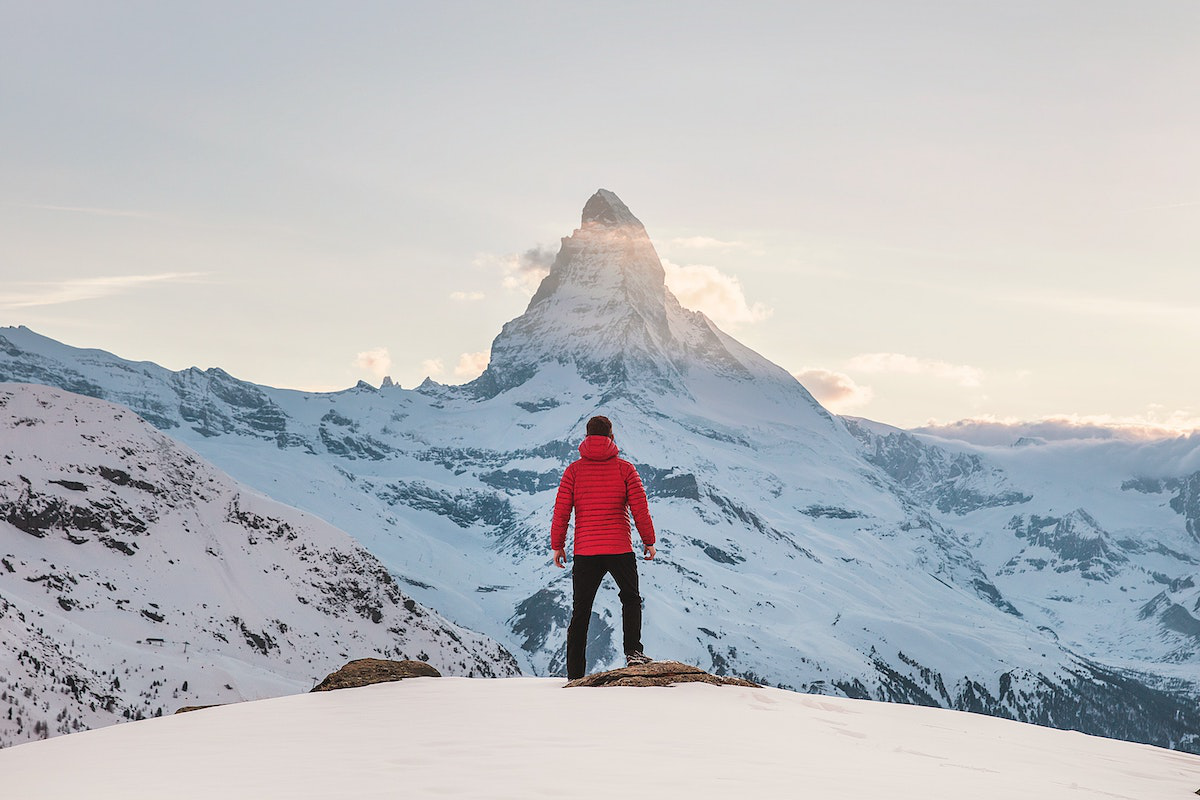

In [ ]:
img

In [ ]:
h1, w1 = np.array(img).shape[0], np.array(img).shape[1]
# h2, w2 = int(h1/3), int(w1/3)

h1, w1

(800, 1200)

## Style Transfer

In [ ]:
!git clone https://github.com/titu1994/Neural-Style-Transfer.git

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 15, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 1393 (delta 5), reused 10 (delta 3), pack-reused 1378
Receiving objects: 100% (1393/1393), 66.59 MiB | 12.03 MiB/s, done.
Resolving deltas: 100% (815/815), done.


In [ ]:
dir_path = "Neural-Style-Transfer"

# Image size
IMAGE_SIZE = h1

# Loss Weights
CONTENT_WEIGHT = 0.025
STYLE_WEIGHT = 1.0
STYLE_SCALE = 1.0
TOTAL_VARIATION_WEIGHT = 8.5e-5
CONTENT_LOSS_TYPE = 0

# Training arguments
NUM_ITERATIONS = 10
MODEL = 'vgg19'
RESCALE_IMAGE = 'false'
MAINTAIN_ASPECT_RATIO = 'false'  # Set to false if OOM occurs

# Transfer Arguments
CONTENT_LAYER = 'conv' + '5_2'  # only change the number 5_2 to something in a similar format
INITIALIZATION_IMAGE = 'content'
POOLING_TYPE = 'max'

# Extra arguments
PRESERVE_COLOR = 'false'
MIN_IMPROVEMENT = 0.0

content img と style img を取得

In [ ]:
CONTENT_IMAGE_FN = "sample_mountain.jpg"
STYLE_IMAGE_FN = "/content/Neural-Style-Transfer/images/inputs/style/candy-style.jpg"
NETWORK = 'INetwork' + '.py'

- Blues Strokes
- banboo_forest
- blue_swirls
- candy-style
- escher_sphere
- frida_kahlo
- japanese_flower_sakai

画風変換

In [ ]:
import os

# 出力のパス等の設定
RESULT_DIR = "generated/"
RESULT_PREFIX = RESULT_DIR + "gen"
FINAL_IMAGE_PATH = RESULT_PREFIX + "_at_iteration_%d.png" % (NUM_ITERATIONS)

if not os.path.exists(RESULT_DIR):
  os.makedirs(RESULT_DIR)

!python {dir_path}/{NETWORK} {CONTENT_IMAGE_FN} {STYLE_IMAGE_FN} {RESULT_PREFIX} \
  --image_size {IMAGE_SIZE} --content_weight {CONTENT_WEIGHT} --style_weight \
  {STYLE_WEIGHT} --style_scale {STYLE_SCALE} --total_variation_weight \
  {TOTAL_VARIATION_WEIGHT} --content_loss_type {CONTENT_LOSS_TYPE} --num_iter \
  {NUM_ITERATIONS} --model {MODEL} --rescale_image {RESCALE_IMAGE} \
  --maintain_aspect_ratio {MAINTAIN_ASPECT_RATIO} --content_layer {CONTENT_LAYER} \
  --init_image {INITIALIZATION_IMAGE} --pool_type {POOLING_TYPE} --preserve_color \
  {PRESERVE_COLOR} --min_improvement {MIN_IMPROVEMENT}

Using TensorFlow backend.
2020-07-24 03:38:04.106516: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-24 03:38:05.556157: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcuda.so.1
2020-07-24 03:38:05.597871: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-07-24 03:38:05.598568: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1561] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2020-07-24 03:38:05.598629: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
2020-07-24 03:38:05.851199: I ten

Tesla P100 だと 800 × 1200 サイズでも行ける。1イテレーション16秒ほど。

K80 だとメモリが足らなくて処理が走らないので、画像サイズを小さくするか、GPUガチャを回す。Colab Pro 日本版が待ち遠しい。

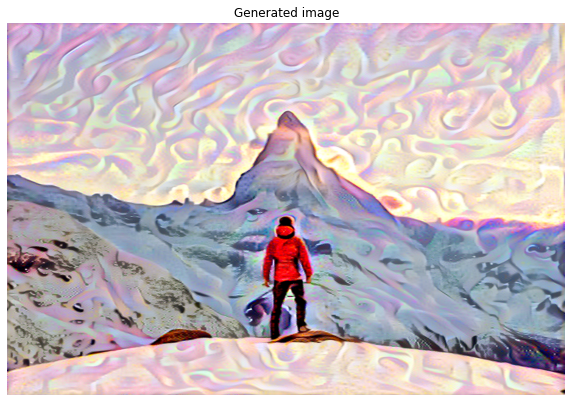

In [ ]:
fig = plt.figure(figsize=(10, 10))
transformed_img = plt.imread(FINAL_IMAGE_PATH)
plt.axis('off')
plt.title('Generated image')
plt.imshow(transformed_img)

In [ ]:
files = sorted(glob("generated/*"))
images = list(map(lambda file: Image.open(file), files))

images[0].save("output.gif", save_all=True, append_images=images[1:], duration=400)

変換過程の gif 作成。generated フォルダの中の並び順に注意。jpg と png が交じる場合は、拡張子にも注意

## Mask Transfer 

まずは Segmentation してマスク画像を取得する

In [ ]:
transform = transforms.Compose([
                                #transforms.Resize((h2, w2)),
                                transforms.ToTensor(),
])

inputs = transform(img)
inputs = inputs.unsqueeze(0)

#推論
model = models.segmentation.deeplabv3_resnet101(pretrained=True, num_classes=21)
model.eval()

pred = model(inputs)["out"]
# pred = F.upsample(pred, size=(h1, w1), mode="bilinear")

# 後処理
mask = torch.argmax(pred[0], 0)

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/checkpoints/resnet101-5d3b4d8f.pth


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet101_coco-586e9e4e.pth" to /root/.cache/torch/checkpoints/deeplabv3_resnet101_coco-586e9e4e.pth


In [ ]:
np.unique(mask) # 0 : background , 1 : person

array([ 0, 15])

True

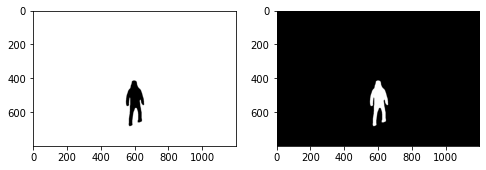

In [ ]:
import cv2 

res1 = np.where(mask == 0, 255, 0) 
res2 = np.where(mask == 0, 0, 255) 

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(res1, cmap="gray")
ax[1].imshow(res2, cmap="gray")

cv2.imwrite("mask_person.jpg", res1)
cv2.imwrite("mask_back.jpg", res2)

**sample_mountain.jpg** : 元画像 

**mask_person.jpg** : 対象が0, 背景が255のマスク画像

**mask_back.jpg** : 対象が255, 背景が0のマスク画像

mask transfer を試す

In [ ]:
!python3 Neural-Style-Transfer/mask_transfer.py "sample_mountain.jpg" "generated/gen_at_iteration_20.png" "mask.jpg"

Traceback (most recent call last):
  File "Neural-Style-Transfer/mask_transfer.py", line 8, in <module>
    from scipy.misc import imread, imresize, imsave
ImportError: cannot import name 'imread'


scipy のバージョンによっては　ImportError: cannot import name 'imread'　が生じる

In [ ]:
# !pip install scipy==1.1.0

     |████████████████████████████████| 31.2MB 105kB/s 
ERROR: umap-learn 0.4.6 has requirement scipy>=1.3.1, but you'll have scipy 1.1.0 which is incompatible.
ERROR: tensorflow 2.2.0 has requirement scipy==1.4.1; python_version >= "3", but you'll have scipy 1.1.0 which is incompatible.
ERROR: plotnine 0.6.0 has requirement scipy>=1.2.0, but you'll have scipy 1.1.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.
  Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1


In [ ]:
!python3 Neural-Style-Transfer/mask_transfer.py "sample_mountain.jpg" "generated/gen_at_iteration_10.png" "mask_back.jpg"

Image saved at path : generated/gen_at_iteration_10_masked.png


generated フォルダ内に画像が出力される。

In [ ]:
!python3 Neural-Style-Transfer/mask_transfer.py "sample_mountain.jpg" "generated/gen_at_iteration_10.png" "mask_person.jpg"

Image saved at path : generated/gen_at_iteration_10_masked.png
